This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [6]:
print('mean:', mean)
print('standard deviation:', std)

mean: [3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
standard deviation: [9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


### Building your model

**Model definition**

In [7]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

In [8]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

**K-fold validation**

In [10]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i+1}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    print('validation data/targets : [',i*num_val_samples,':',(i + 1) * num_val_samples,']')
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #1
validation data/targets : [ 0 : 101 ]
Processing fold #2
validation data/targets : [ 101 : 202 ]
Processing fold #3
validation data/targets : [ 202 : 303 ]
Processing fold #4
validation data/targets : [ 303 : 404 ]


In [11]:
all_scores

[2.131673574447632, 2.393343448638916, 2.3222036361694336, 2.3852057456970215]

In [12]:
np.mean(all_scores)

np.float64(2.3081066012382507)

**Saving the validation logs at each fold**

In [14]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i+1}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


**Building the history of successive mean K-fold validation scores**

In [16]:
np.array(all_mae_histories).shape

(4, 500)

In [21]:
np.array(all_mae_histories[0])  # mae for 1st fold(500 epochs)

array([18.16456413, 14.42511177, 10.27029037,  6.972229  ,  5.17973518,
        4.17723894,  3.43741679,  3.18190932,  2.92602682,  2.81117535,
        2.74612665,  2.61700797,  2.55010462,  2.46299911,  2.53995538,
        2.44755363,  2.34354901,  2.32988954,  2.2710669 ,  2.30402899,
        2.20879555,  2.18481541,  2.18963385,  2.15638709,  2.16835213,
        2.10219812,  2.17667389,  2.08807445,  2.21439624,  2.12420678,
        2.0576179 ,  2.17430282,  2.12514567,  2.10000396,  2.05491543,
        2.21026039,  2.05966043,  2.01981044,  2.03829288,  2.13588738,
        2.0022254 ,  2.02376842,  2.06483579,  2.05849528,  2.04845786,
        1.98858547,  2.10330915,  1.99968147,  1.98935485,  1.99342084,
        2.0275712 ,  2.04891777,  2.0403924 ,  1.95983505,  2.05280471,
        2.02703834,  2.09324718,  2.0039072 ,  2.21951795,  2.02787304,
        2.00461864,  2.03496146,  1.98369551,  1.99396586,  2.20281649,
        1.93516803,  1.92353868,  1.99386692,  1.91897488,  2.10

In [22]:
print('average mae for epoch #1 :', np.mean([x[0] for x in all_mae_histories]))

average mae for epoch #1 : 19.448523998260498


In [23]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [24]:
average_mae_history # 500 averages

[np.float64(19.448523998260498),
 np.float64(16.06638503074646),
 np.float64(11.905464887619019),
 np.float64(8.07422685623169),
 np.float64(5.943338513374329),
 np.float64(4.796095609664917),
 np.float64(4.0175822377204895),
 np.float64(3.619621753692627),
 np.float64(3.4211791157722473),
 np.float64(3.288287937641144),
 np.float64(3.166610836982727),
 np.float64(3.061623752117157),
 np.float64(3.0054792165756226),
 np.float64(2.9489551782608032),
 np.float64(2.849814474582672),
 np.float64(2.7965781688690186),
 np.float64(2.7933191061019897),
 np.float64(2.745206356048584),
 np.float64(2.6448062658309937),
 np.float64(2.637235939502716),
 np.float64(2.663556933403015),
 np.float64(2.5671459436416626),
 np.float64(2.60334450006485),
 np.float64(2.5436107516288757),
 np.float64(2.558482825756073),
 np.float64(2.5247103571891785),
 np.float64(2.5257195234298706),
 np.float64(2.510998785495758),
 np.float64(2.513465106487274),
 np.float64(2.504323720932007),
 np.float64(2.47046160697937)

**Plotting validation scores**

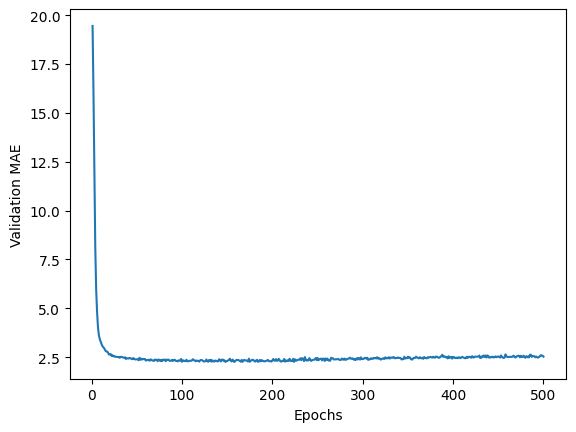

In [25]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

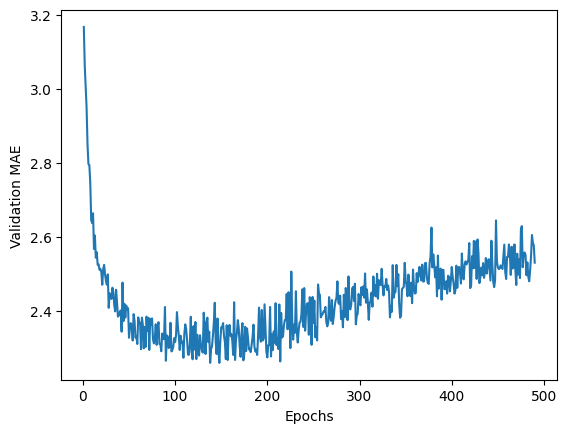

In [26]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()  # overfitting at around 130th epoch

**Training the final model**

In [27]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 12.0563 - mae: 2.4532


In [28]:
test_mae_score

2.6446692943573

### Generating predictions on new data

In [29]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([6.71392], dtype=float32)

In [34]:
print(predictions[100], test_targets[100])

[29.099073] 26.7


### Wrapping up

## Summary